# download sentinel 2 images from copernicus open access hub

- read sentinel sat docu
- read sentinel hub docu
- get farm plot location coordinates
- pick one location
- define bounding box around it
- create geojson
- define date range
- retrieve available images
- select image
- download image

In [1]:
import os
import cv2
from datetime import date
import json
import itertools
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from sentinelhub import pixel_to_utm, utm_to_pixel
import utm
import pandas as pd

In [2]:
pd.set_option('display.max_columns', 500)

## collect data

In [3]:
geojson_path = 'data/target_zone_sioma.geojson'
#geojson_path = 'data/target_zone_mulele.geojson'

with open('secrets/sentinel_api_credentials.json', 'r') as infile:
    credentials = json.load(infile)

api = SentinelAPI(credentials['username'], credentials['password'], 'https://scihub.copernicus.eu/dhus')

shape = geojson_to_wkt(read_geojson(geojson_path))

images = api.query(
    shape,
    date=(date(2022, 4, 1), date(2022, 4, 30)),
    platformname='Sentinel-2',
    processinglevel='Level-2A',
    cloudcoverpercentage=(0, 10)
    )

images_df = api.to_dataframe(images)

In [4]:
len(images)

3

In [5]:
images_df.head()

,title,link,link_alternative,link_icon,summary,ondemand,generationdate,beginposition,endposition,ingestiondate,orbitnumber,relativeorbitnumber,illuminationazimuthangle,illuminationzenithangle,vegetationpercentage,notvegetatedpercentage,waterpercentage,unclassifiedpercentage,mediumprobacloudspercentage,highprobacloudspercentage,snowicepercentage,cloudcoverpercentage,level1cpdiidentifier,gmlfootprint,footprint,format,processingbaseline,platformname,filename,instrumentname,instrumentshortname,size,s2datatakeid,producttype,platformidentifier,orbitdirection,platformserialidentifier,processinglevel,datastripidentifier,granuleidentifier,identifier,uuid
50d95eaf-3243-451c-8cd0-6f67d3deba91,S2A_MSIL2A_20220425T081611_N0400_R121_T34KGG_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2022-04-25T08:16:11.024Z, Instrument: MS...",false,2022-04-25 10:51:24,2022-04-25 08:16:11.024,2022-04-25 08:16:11.024,2022-04-25 14:15:41.743,35725,121,40.774020,38.754043,78.582883,16.127621,0.617294,0.613651,1.420941,0.773694,0.0,2.355324,S2A_OPER_MSI_L1C_TL_VGS1_20220425T101315_A0357...,"<gml:Polygon srsName=""http://www.opengis.net/g...",MULTIPOLYGON (((22.880939357301603 -17.2645896...,SAFE,04.00,Sentinel-2,S2A_MSIL2A_20220425T081611_N0400_R121_T34KGG_2...,Multi-Spectral Instrument,MSI,1.13 GB,GS2A_20220425T081611_035725_N04.00,S2MSI2A,2015-028A,DESCENDING,Sentinel-2A,Level-2A,S2A_OPER_MSI_L2A_DS_VGS1_20220425T105124_S2022...,S2A_OPER_MSI_L2A_TL_VGS1_20220425T105124_A0357...,S2A_MSIL2A_20220425T081611_N0400_R121_T34KGG_2...,50d95eaf-3243-451c-8cd0-6f67d3deba91
1ecf07ed-e59f-4b7d-98e5-d05dab58b7a3,S2B_MSIL2A_20220420T081559_N0400_R121_T34KGG_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2022-04-20T08:15:59.024Z, Instrument: MS...",false,2022-04-20 11:50:16,2022-04-20 08:15:59.024,2022-04-20 08:15:59.024,2022-04-20 14:31:58.743,26745,121,42.872348,37.667510,83.273816,15.340762,0.567085,0.772967,0.012727,0.001347,0.0,0.014074,S2B_OPER_MSI_L1C_TL_VGS4_20220420T104911_A0267...,"<gml:Polygon srsName=""http://www.opengis.net/g...",MULTIPOLYGON (((22.880939357301603 -17.2645896...,SAFE,04.00,Sentinel-2,S2B_MSIL2A_20220420T081559_N0400_R121_T34KGG_2...,Multi-Spectral Instrument,MSI,1.14 GB,GS2B_20220420T081559_026745_N04.00,S2MSI2A,2017-013A,DESCENDING,Sentinel-2B,Level-2A,S2B_OPER_MSI_L2A_DS_VGS4_20220420T115016_S2022...,S2B_OPER_MSI_L2A_TL_VGS4_20220420T115016_A0267...,S2B_MSIL2A_20220420T081559_N0400_R121_T34KGG_2...,1ecf07ed-e59f-4b7d-98e5-d05dab58b7a3
3aa91b46-2989-4d5b-847e-2ce9842d3e25,S2A_MSIL2A_20220415T081611_N0400_R121_T34KGG_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2022-04-15T08:16:11.024Z, Instrument: MS...",false,2022-04-15 10:50:48,2022-04-15 08:16:11.024,2022-04-15 08:16:11.024,2022-04-15 14:39:09.461,35582,121,45.135012,36.546331,77.788788,15.230460,0.406853,1.639042,0.917950,0.259754,0.0,4.639255,S2A_OPER_MSI_L1C_TL_VGS1_20220415T101143_A0355...,"<gml:Polygon srsName=""http://www.opengis.net/g...",MULTIPOLYGON (((22.880939357301603 -17.2645896...,SAFE,04.00,Sentinel-2,S2A_MSIL2A_20220415T081611_N0400_R121_T34KGG_2...,Multi-Spectral Instrument,MSI,1.12 GB,GS2A_20220415T081611_035582_N04.00,S2MSI2A,2015-028A,DESCENDING,Sentinel-2A,Level-2A,S2A_OPER_MSI_L2A_DS_VGS1_20220415T105048_S2022...,S2A_OPER_MSI_L2A_TL_VGS1_20220415T105048_A0355...,S2A_MSIL2A_20220415T081611_N0400_R121_T34KGG_2...,3aa91b46-2989-4d5b-847e-2ce9842d3e25


In [6]:
key_columns = ['platformserialidentifier', 'processinglevel', 'cloudcoverpercentage', 'vegetationpercentage', 'beginposition']
images_df[key_columns].head()

,platformserialidentifier,processinglevel,cloudcoverpercentage,vegetationpercentage,beginposition
50d95eaf-3243-451c-8cd0-6f67d3deba91,Sentinel-2A,Level-2A,2.355324,78.582883,2022-04-25 08:16:11.024
1ecf07ed-e59f-4b7d-98e5-d05dab58b7a3,Sentinel-2B,Level-2A,0.014074,83.273816,2022-04-20 08:15:59.024
3aa91b46-2989-4d5b-847e-2ce9842d3e25,Sentinel-2A,Level-2A,4.639255,77.788788,2022-04-15 08:16:11.024


In [7]:
uuid = images_df.sort_values('cloudcoverpercentage', ascending=True).head(1)['uuid'][0]
uuid

'1ecf07ed-e59f-4b7d-98e5-d05dab58b7a3'

In [8]:
uuid = images_df.sort_values('cloudcoverpercentage', ascending=True).head(1)['uuid'][0]
uuid

'1ecf07ed-e59f-4b7d-98e5-d05dab58b7a3'

In [9]:
%%time

#api.download(uuid)

CPU times: user 10 µs, sys: 2 µs, total: 12 µs
Wall time: 19.8 µs


## explore data

In [10]:
image_folder = 'data/S2B_MSIL2A_20220420T081559_N0400_R121_T34KGG_20220420T115016.SAFE'

In [11]:
def get_band(image_folder, band, resolution=10):
    subfolder = [f for f in os.listdir(image_folder + "/GRANULE") if f[0]  == "L"][0]
    image_folder_path  = f"{image_folder}/GRANULE/{subfolder}/IMG_DATA/R{resolution}m"
    image_files = [im for im in os.listdir(image_folder_path) if im[-4:] == ".jp2"]
    selected_file = [im for im in image_files if im.split("_")[2] == band][0]
    
    with rasterio.open(f"{image_folder_path}/{selected_file}") as infile:
        img = infile.read(1)
            
    return img

In [12]:
band_dict = {}

for band in ["B02", "B03", "B04", "B08"]:
    band_dict[band] = get_band(image_folder, band, 10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


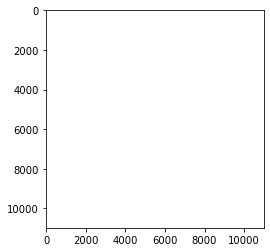

In [13]:
# Recreating an RGB image 
img = cv2.merge((band_dict["B04"], band_dict["B03"], band_dict["B02"]))
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


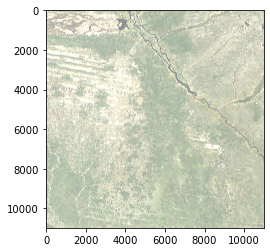

In [14]:
img_processed = img / 8
img_processed = img_processed.astype(int)
plt.imshow(img_processed)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


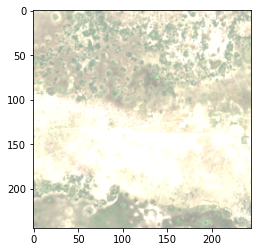

In [15]:
frag_count = 45
frag_size = int(img_processed.shape[0] / frag_count)
frag_dict = {}
    
for y, x in itertools.product(range(frag_count), range(frag_count)):
    frag_dict[(x, y)] = img_processed[y*frag_size: (y+1)*frag_size,  x*frag_size: (x+1)*frag_size, :]  
    
plt.imshow(frag_dict[(10, 10)])